## **Importing Libraries**

Importing required libraries for handling the data and Anomaly Detection

In [1]:
# Importing libraries required for handling the data
import pandas as pd
import numpy as np

# Importing libraries required for visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries required for importing the data
from google.colab import files
import io

# Importing libraries for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing ML Models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

Uploading the data file

In [3]:
uploaded = files.upload()

Saving cpu_utilization_asg_misconfiguration.csv to cpu_utilization_asg_misconfiguration.csv


Reading the data file into a pandas dataframe.

In [4]:
path = io.BytesIO(uploaded['cpu_utilization_asg_misconfiguration.csv'])
df = pd.read_csv(path)

## **Pre-Processing the dataset**

Converting the timestamp feature into a datetime format for pandas, using that as index and sorting the dataset.<br>

Cleaning the data by dropping any na values, none of those exists in the dataset as nothing gets dropped.

Also creating the one day usage dataset using the index.

Printing the head and tail of the dataset.

In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")
df.dropna(inplace = True) 
df = df.set_index("timestamp")
df.sort_index(inplace=True)
df_oneDayUsage = df[df.index <= '2014-05-15 01:14:00']
print("Dataset Shape:",df.shape)
df.head()

Dataset Shape: (18050, 1)


,value
timestamp,
2014-05-14 01:14:00,85.835
2014-05-14 01:19:00,88.167
2014-05-14 01:24:00,44.595
2014-05-14 01:29:00,56.282
2014-05-14 01:34:00,36.534


In [6]:
df.tail()

,value
timestamp,
2014-07-15 16:59:00,13.498
2014-07-15 17:04:00,19.831
2014-07-15 17:09:00,27.165
2014-07-15 17:14:00,12.873
2014-07-15 17:19:00,12.129


After looking at the data we can see the data is in 5 minutes interval, and we have 18,050 data points starting on May 14th 2014 at 01:14:00 and ending on July 15th 2014 at 17:19:00. 

Visualizing the whole dataset

[Text(0, 0.5, 'Value'), Text(0.5, 0, 'Timestamp')]

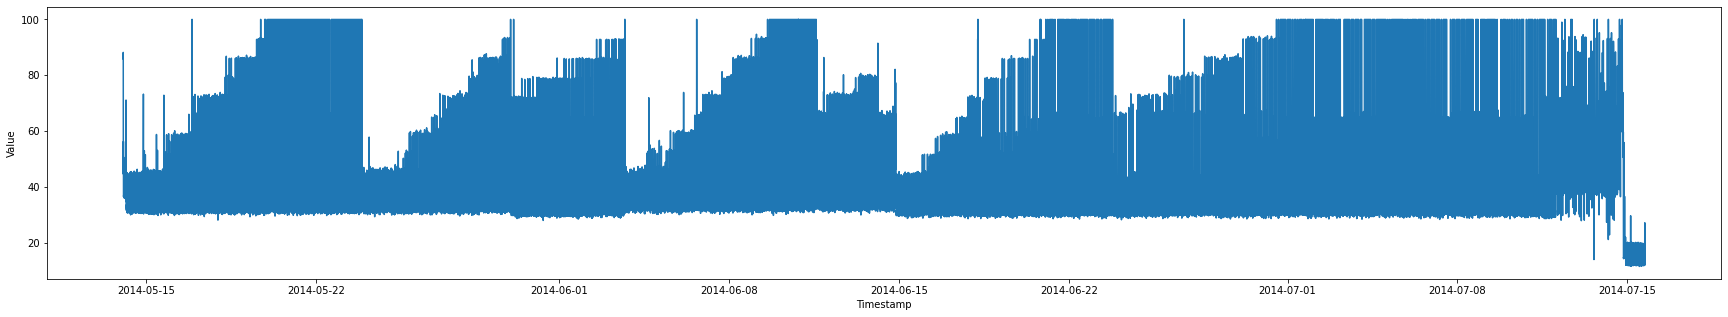

In [7]:
plt.figure(figsize=(30,5))
ax = sns.lineplot(x=df.index,y='value', data=df)
ax.set(ylabel='Value', xlabel='Timestamp')

As we can not see much whats going on in the dataset when we plot the whole dataset, next I try to limit the dataset to a few parts and plot them for a better visualization and understanding of the data.

Visualizing parts of data set
 * One Day
 * One Week
 * May
 * One Month


Text(0, 0.5, 'Value')

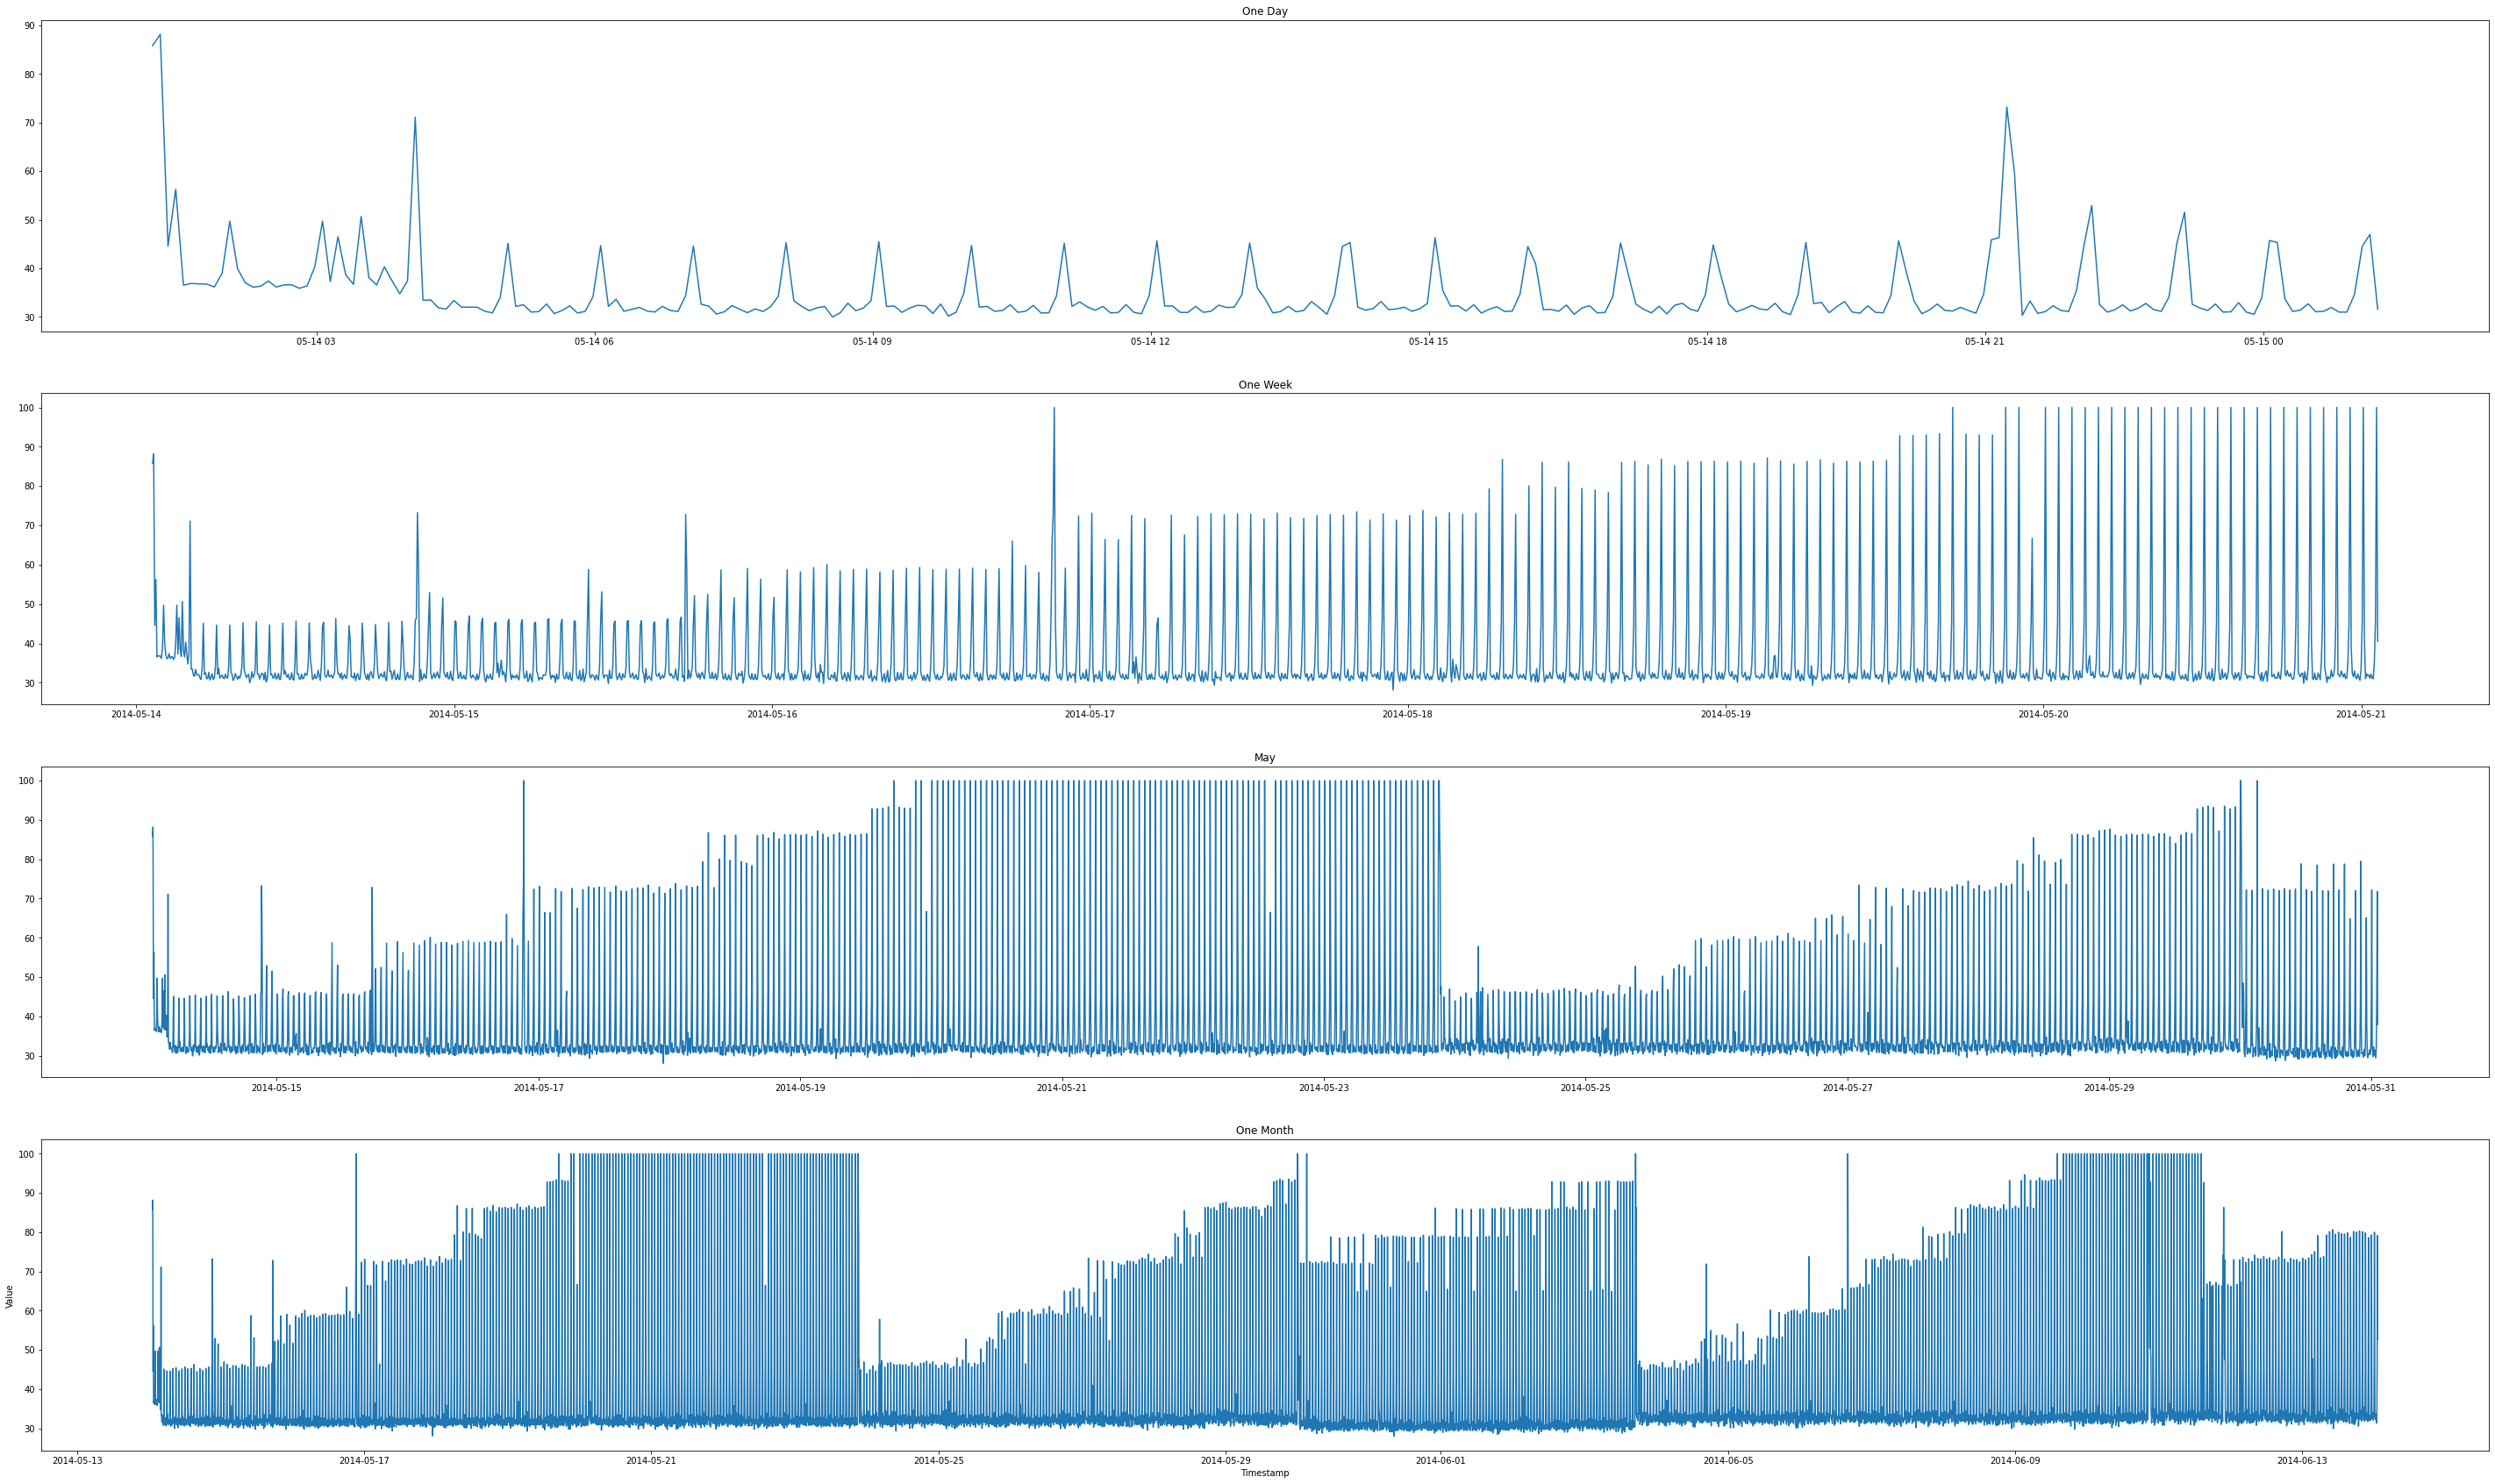

In [8]:
fig, axs = plt.subplots(4, figsize=(50,30))
axs[0].plot(df.index[df.index <= '2014-05-15 01:14:00'],'value', data = df[df.index <= '2014-05-15 01:14:00'],label='One Day')
axs[0].set_title('One Day')

axs[1].plot(df.index[df.index <= '2014-05-21 01:14:00'],'value', data = df[df.index <= '2014-05-21 01:14:00'], label='One Week')
axs[1].set_title('One Week')

axs[2].plot(df.index[df.index <= '2014-05-31 01:14:00'],'value', data = df[df.index <= '2014-05-31 01:14:00'], label = 'May')
axs[2].set_title('May')

axs[3].plot(df.index[df.index <= '2014-06-14 01:14:00'],'value', data = df[df.index <= '2014-06-14 01:14:00'], label = 'One Month')
axs[3].set_title('One Month')

axs[3].set_xlabel('Timestamp')
axs[3].set_ylabel('Value')

Creating a 10 minutes average usage for a single day, as the dataset is in 5 minutes interval we know there are 2 values within a 10 minute interval so averaging on those two values and visualizing the difference.

[Text(0, 0.5, 'Value'), Text(0.5, 0, 'Per 10 Minutes')]

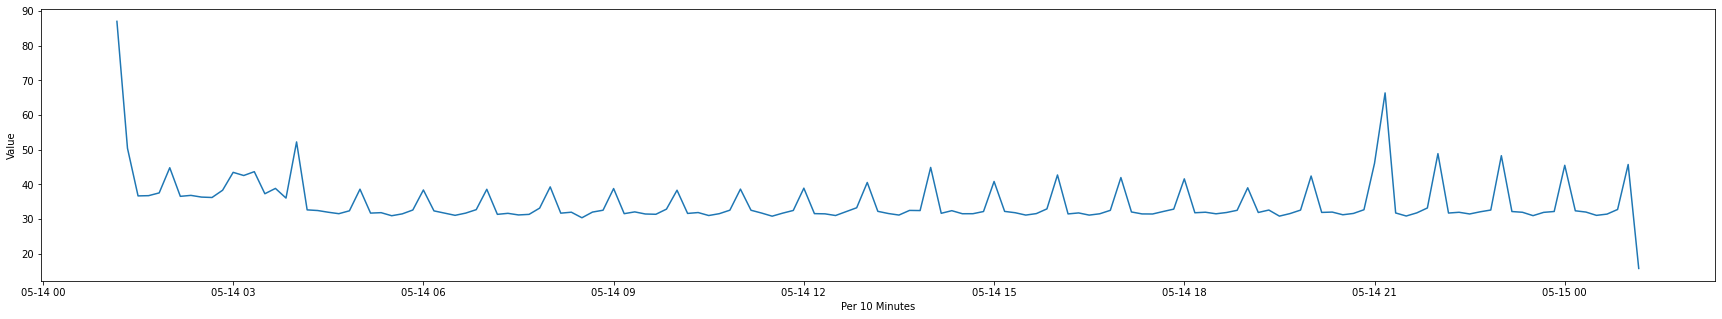

In [9]:
timeSeries_Per10mins = (df_oneDayUsage['value'].resample('10min').sum()/2).to_frame() # Calculating 10 min average usage on a single day
# print(timeSeries_Per10mins.shape)
# timeSeries_Per10mins.head()
plt.figure(figsize=(30,5))
ax = sns.lineplot(x=timeSeries_Per10mins.index,y='value', data=timeSeries_Per10mins)
ax.set(ylabel='Value', xlabel='Per 10 Minutes')

As we can see from the Plotted graph above, the 10 Minute average just smooths out the one day usage (5 minute interval) graph with less small spikes, I think this could be helpful for anomaly detection as this reduces some noise in the dataset.

**Shape of all the datasets used**

In [10]:
print("Whole Dataset Shape:", df.shape)
print("One day usage df shape:", df_oneDayUsage.shape)
print("10 Mins average df shape:", timeSeries_Per10mins.shape)

Whole Dataset Shape: (18050, 1)
One day usage df shape: (289, 1)
10 Mins average df shape: (145, 1)


From the shapes above we can see that the whole dataset has 18,050 values, one day is 289 values, and the 10 min average of one day usage has 145 values which is half of the original dataset used for averaging.

## **Scaling the dataset**

A scaled dataset is good for training a ML model so we scale the different dataframes using the standard scaler function from the sklearn preprocessing library.

In [11]:
scaler = StandardScaler()
scaler_odu = StandardScaler()
scaler_avg = StandardScaler()

scaled_df = pd.DataFrame(data=scaler.fit_transform(np.array(df['value']).reshape(-1,1)),index=df.index,columns=['value'])
scaled_oneday_df = pd.DataFrame(data=scaler_odu.fit_transform(np.array(df_oneDayUsage['value']).reshape(-1,1)),index=df_oneDayUsage.index,columns=['value'])
scaled_10mins = pd.DataFrame(scaler_avg.fit_transform(np.array(timeSeries_Per10mins['value']).reshape(-1,1)),index=timeSeries_Per10mins.index,columns=['value'])

## **Implementing ML Models**

* Local Outlier Factor
* Isolation Forest
* DBSCAN

Implemented on:

* The whole dataset
* One day usage (24 hours)
* One day usage 10 mins average

Visualized the predicted anomalies:<br>
 **Blue Line - Actual data**<br>
 **Red Dots - Anomalies Detected**

In [12]:
pd.options.mode.chained_assignment = None  # default='warn'

# Initializing models with hyperparameters
model_lof = LocalOutlierFactor(contamination= 0.1,n_neighbors=10)
model_if =  IsolationForest(contamination= 0.1,max_samples=100, random_state=1)
model_DBSCAN = DBSCAN(eps = 0.01, min_samples=5)

# Fitting and predicting on the whole dataset with different models.
df['Predictions_DBSCAN'] = model_DBSCAN.fit_predict(scaled_df)
df['Predictions_LocalOutlierFactor'] = model_lof.fit_predict(scaled_df)
df['Predictions_IsolationForest'] = model_if.fit_predict(scaled_df)

# Fitting and predicting for one day usage with different models.
df_oneDayUsage['Predictions_DBSCAN'] = model_DBSCAN.fit_predict(scaled_oneday_df)
df_oneDayUsage['Predictions_LocalOutlierFactor'] = model_lof.fit_predict(scaled_oneday_df)
df_oneDayUsage['Predictions_IsolationForest'] = model_if.fit_predict(scaled_oneday_df)

# Fitting and predicting for one day 10 mins average with different models.
timeSeries_Per10mins['Predictions_DBSCAN'] = model_DBSCAN.fit_predict(scaled_10mins)
timeSeries_Per10mins['Predictions_LocalOutlierFactor'] = model_lof.fit_predict(scaled_10mins)
timeSeries_Per10mins['Predictions_IsolationForest'] = model_if.fit_predict(scaled_10mins)

# df.head()
# df_oneDayUsage.head()
# timeSeries_Per10mins.head()

Plotting the graphs for the predictions on one day usage.

From the plotted graphs we can see that we can detect anomalies on a single day of data but has limitted data points and so maybe not as good as a model trained on the whole dataset. The trained models predict anomalies very well, but we can also see small spikes which do not seem like an anomaly detected as one. This is improved when we use the 10 minute average shown in the execution of the next cell.

The best performing model for one day usage is Isolation Forest as we can see from the graphs.

Text(0.5, 1.0, 'DBSCAN')

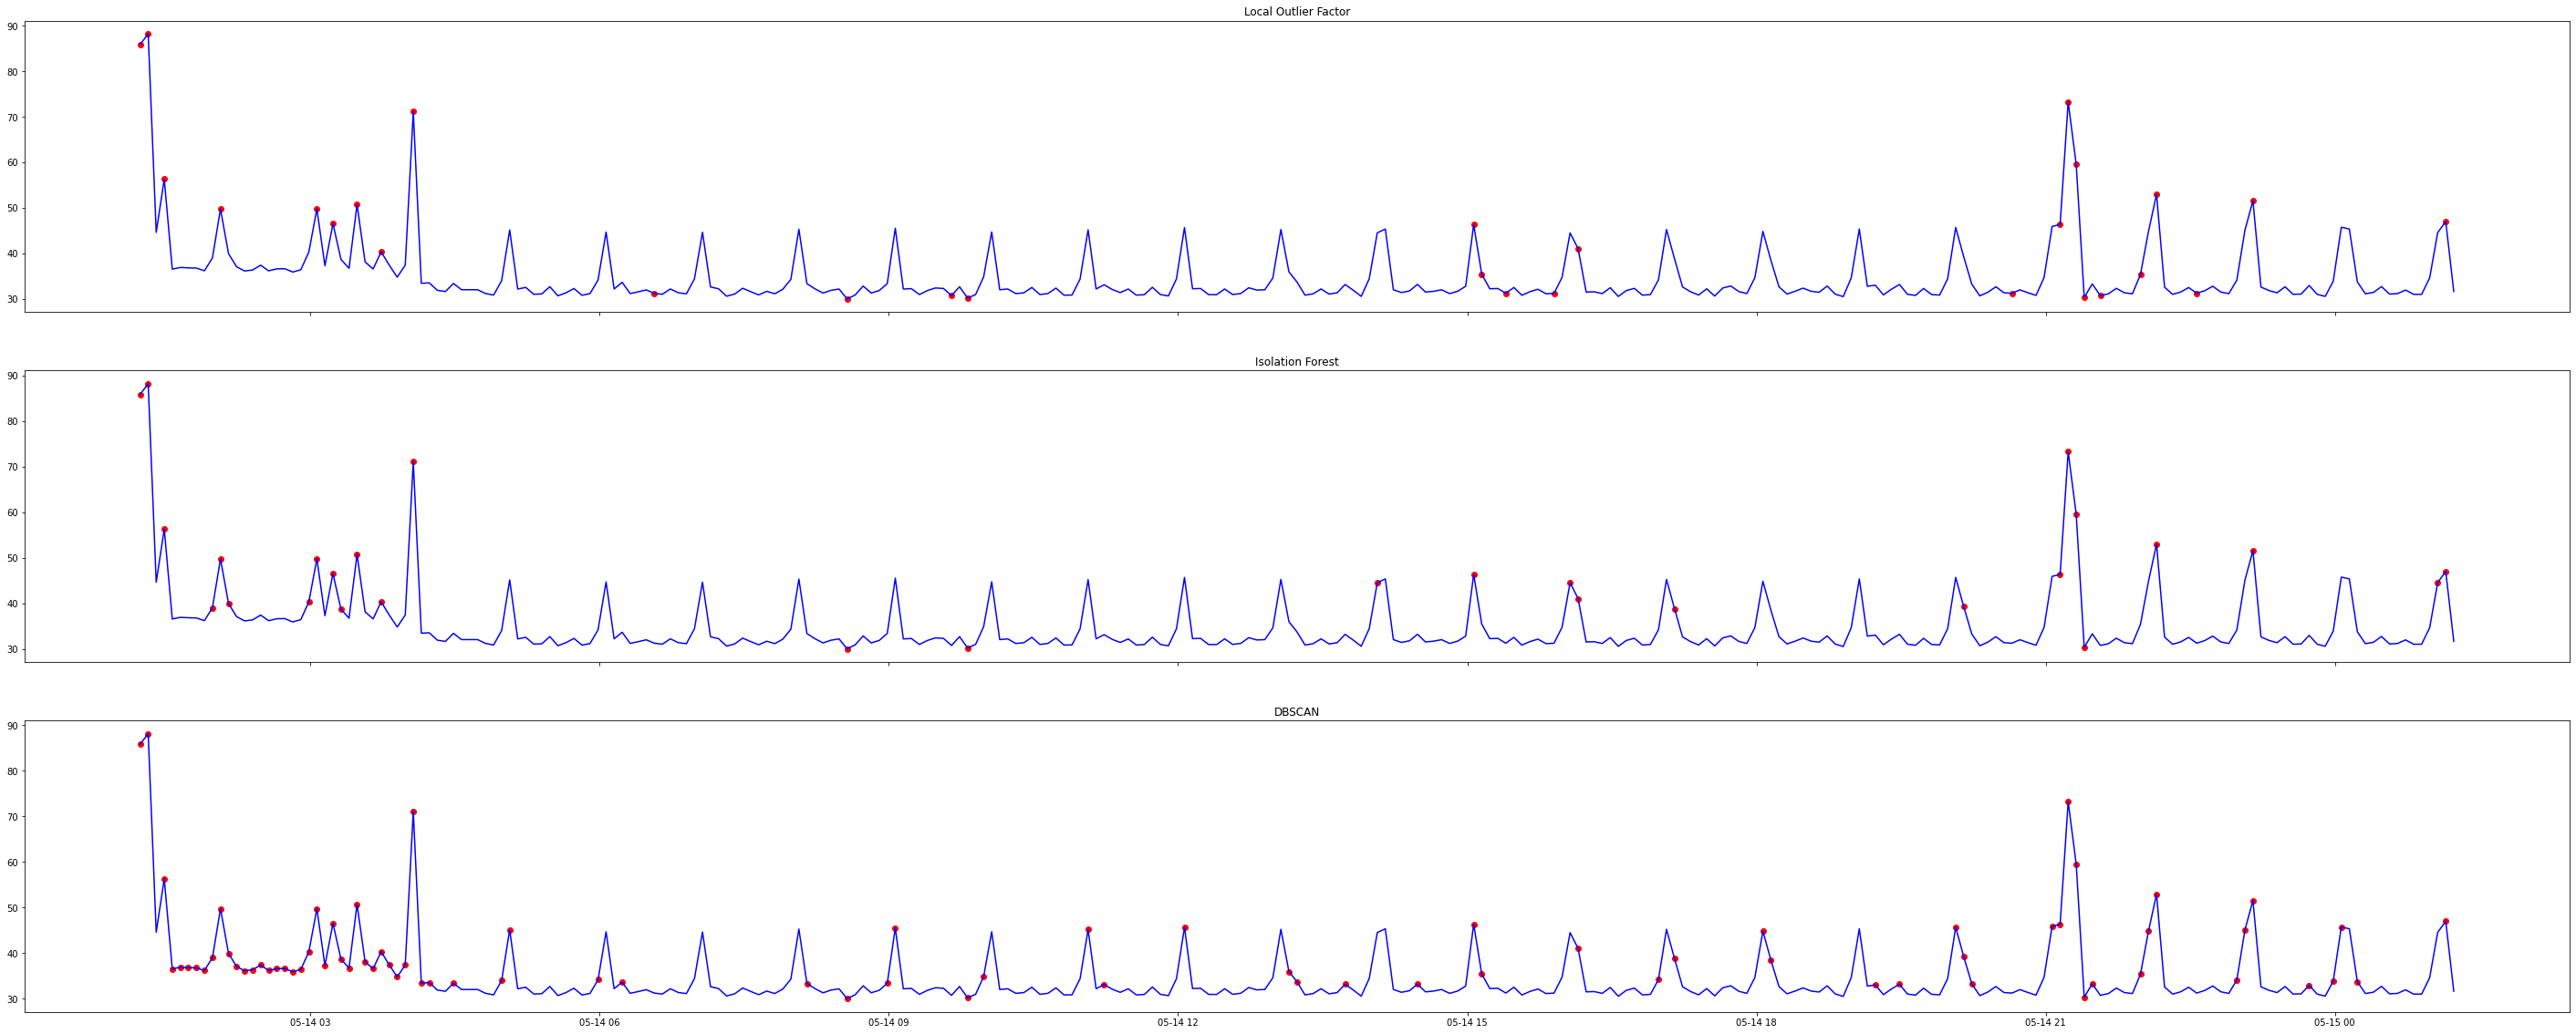

In [13]:
lof_outliers = df_oneDayUsage.loc[df_oneDayUsage['Predictions_LocalOutlierFactor'] == -1, ['value']] # -1 is an anomaly
if_outliers = df_oneDayUsage.loc[df_oneDayUsage['Predictions_IsolationForest'] == -1, ['value']] # -1 is an anomaly
dbscan_outliers = df_oneDayUsage.loc[df_oneDayUsage['Predictions_DBSCAN'] == -1, ['value']] # -1 is an anomaly

fig, axs = plt.subplots(3, figsize=(50,20),sharex=True,sharey=True)
axs[0].plot(df_oneDayUsage.index, df_oneDayUsage['value'], color='blue', label = 'Data')
axs[0].scatter(x=lof_outliers.index,y=lof_outliers['value'], color='red', label = 'LOF Anomaly')
axs[0].set_title('Local Outlier Factor')

axs[1].plot(df_oneDayUsage.index, df_oneDayUsage['value'], color='blue', label = 'Data')
axs[1].scatter(x=if_outliers.index,y=if_outliers['value'], color='red', label = 'IF Anomaly')
axs[1].set_title('Isolation Forest')

axs[2].plot(df_oneDayUsage.index, df_oneDayUsage['value'], color='blue', label = 'Data')
axs[2].scatter(x=dbscan_outliers.index,y=dbscan_outliers['value'], color='red', label = 'DBSCAN Anomaly')
axs[2].set_title('DBSCAN')

Plotting graphs for the predictions on 10 minute average dataframe.

As we can see from the plots above, the smoothed out data helps the algorithm to ignore the small spikes and detect the major anomalies, we can see that by comparing the plotted graphs for 10 minute average and one day usage (5 min interval). While the algorithm still detects the small spikes as anomalies I feel the average did help a bit if not a lot.

The best performing model for 10 minutes average again comes to be isolation forest. DBSCAN ends up predicting every spike up as an anomaly while this could be what we want, but looking at the data I think Isolation forest did a better job.

Text(0.5, 1.0, 'DBSCAN')

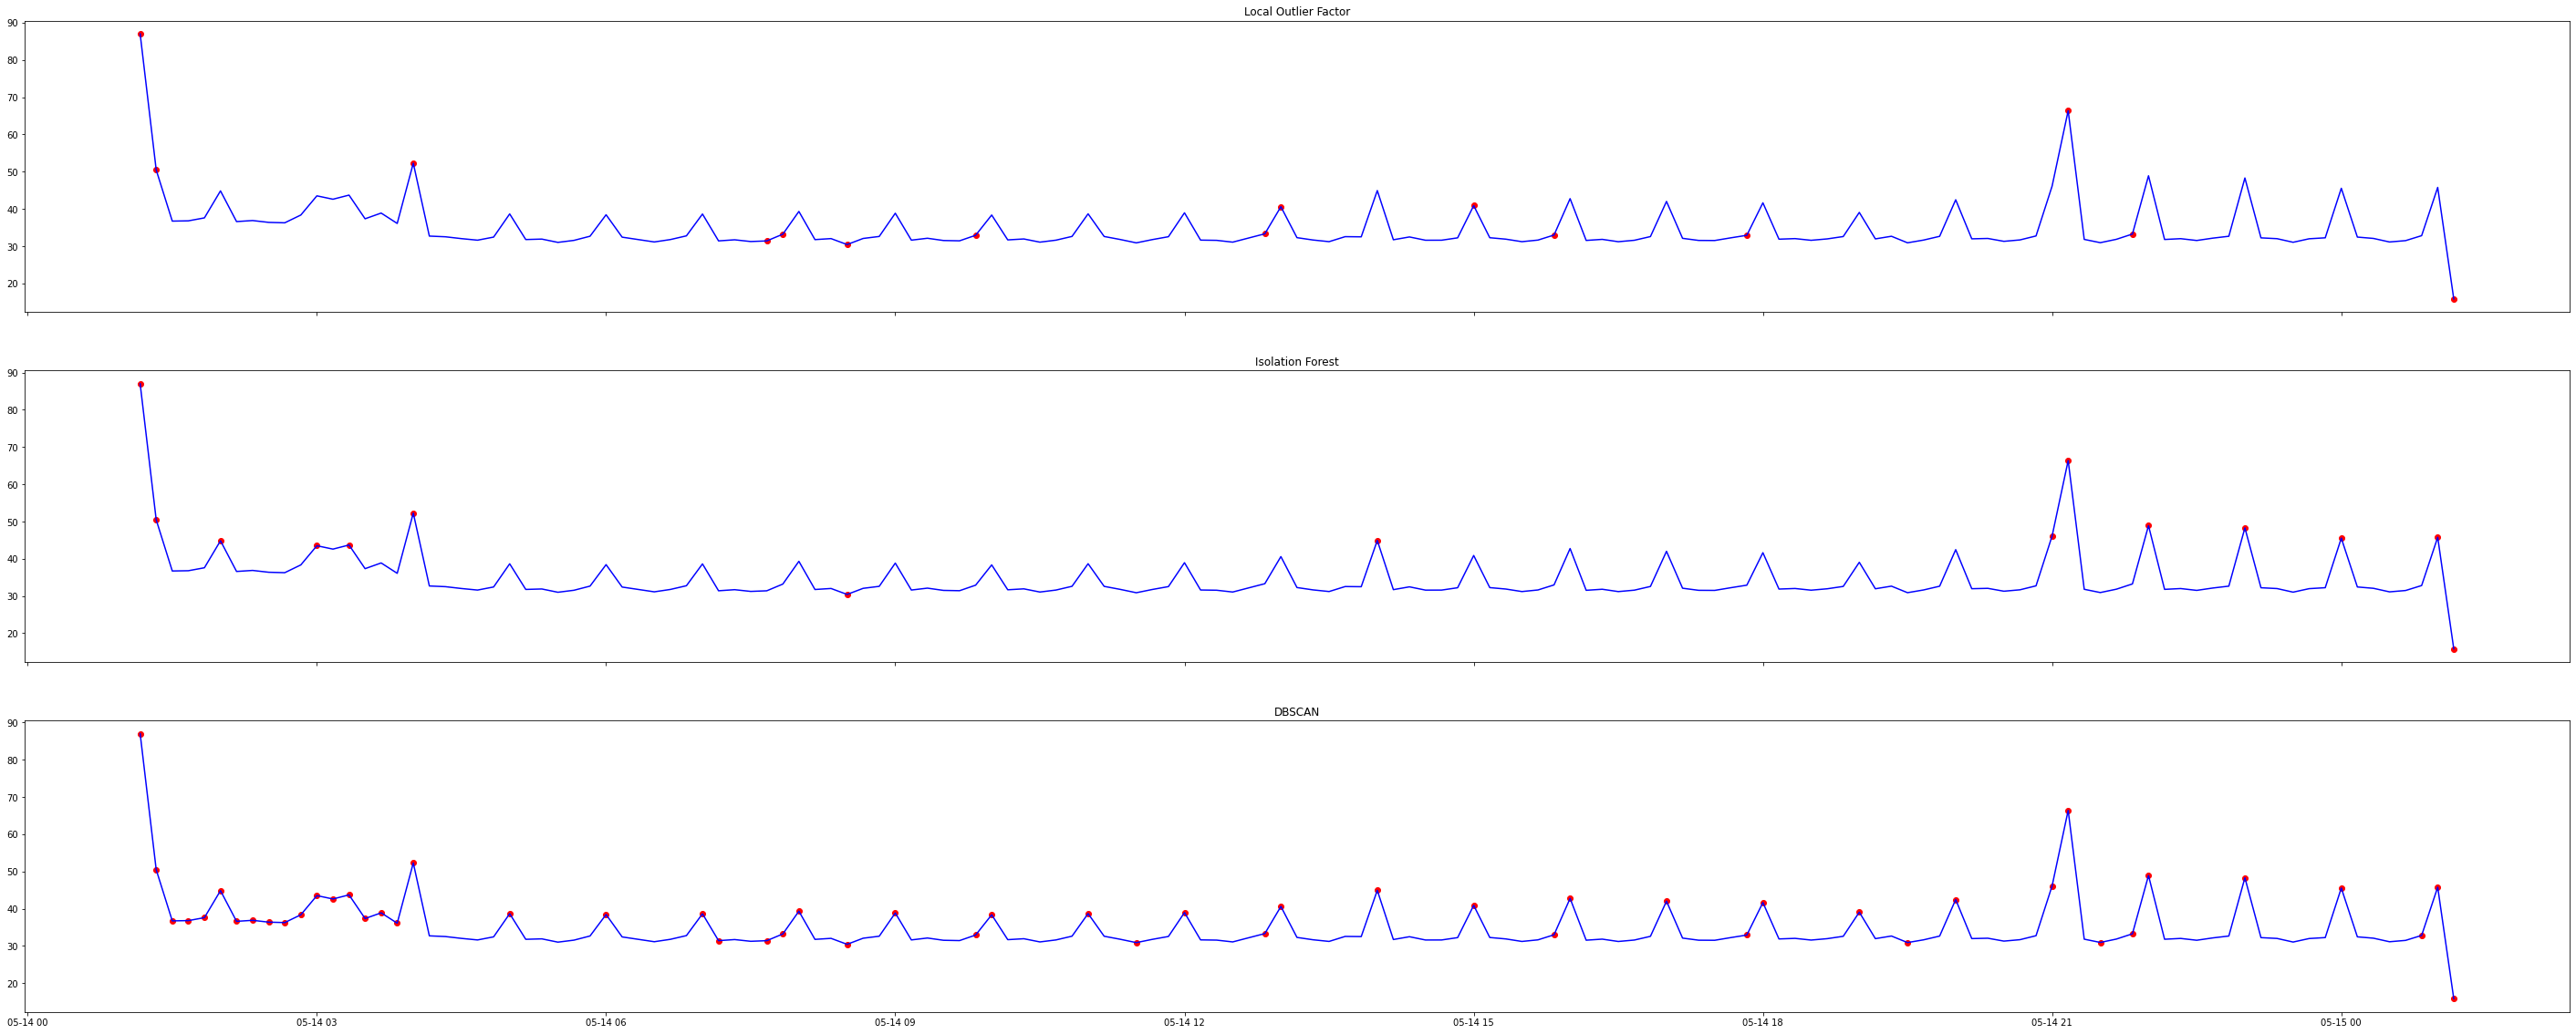

In [14]:
lof_outliers = timeSeries_Per10mins.loc[timeSeries_Per10mins['Predictions_LocalOutlierFactor'] == -1, ['value']] # -1 is an anomaly
if_outliers = timeSeries_Per10mins.loc[timeSeries_Per10mins['Predictions_IsolationForest'] == -1, ['value']] # -1 is an anomaly
dbscan_outliers = timeSeries_Per10mins.loc[timeSeries_Per10mins['Predictions_DBSCAN'] == -1, ['value']] # -1 is an anomaly

fig, axs = plt.subplots(3, figsize=(50,20),sharex=True,sharey=True)
axs[0].plot(timeSeries_Per10mins.index, timeSeries_Per10mins['value'], color='blue', label = 'Data')
axs[0].scatter(x=lof_outliers.index,y=lof_outliers['value'], color='red', label = 'LOF Anomaly')
axs[0].set_title('Local Outlier Factor')

axs[1].plot(timeSeries_Per10mins.index, timeSeries_Per10mins['value'], color='blue', label = 'Data')
axs[1].scatter(x=if_outliers.index,y=if_outliers['value'], color='red', label = 'IF Anomaly')
axs[1].set_title('Isolation Forest')

axs[2].plot(timeSeries_Per10mins.index, timeSeries_Per10mins['value'], color='blue', label = 'Data')
axs[2].scatter(x=dbscan_outliers.index,y=dbscan_outliers['value'], color='red', label = 'DBSCAN Anomaly')
axs[2].set_title('DBSCAN')

Plotting graphs for the predictions on the whole dataset given.

As the whole dataset is too much to visualize, I have restricted the data to only first 2000 data points for a better visualization/understanding of the predictions made as when the whole data is plotted it is not much distinguishable.

As the whole dataset is limited to first 2000 entries, the number of anomaly predicted are also liitted to only show for the data entries plotted.

From this we can see that Local Outlier Factor predicted 218 anomalies in the first 2000 data points, whereas the isolation forest only predicts 105 in those entries. The lowest anomalies detected in the first 2000 datapoints is by DBSCAN with only 2 anomalies.

From the graphs we can see, Isolation forest performs the best as it has the most number of correct predictions according to me.

Text(0.5, 1.0, 'DBSCAN')

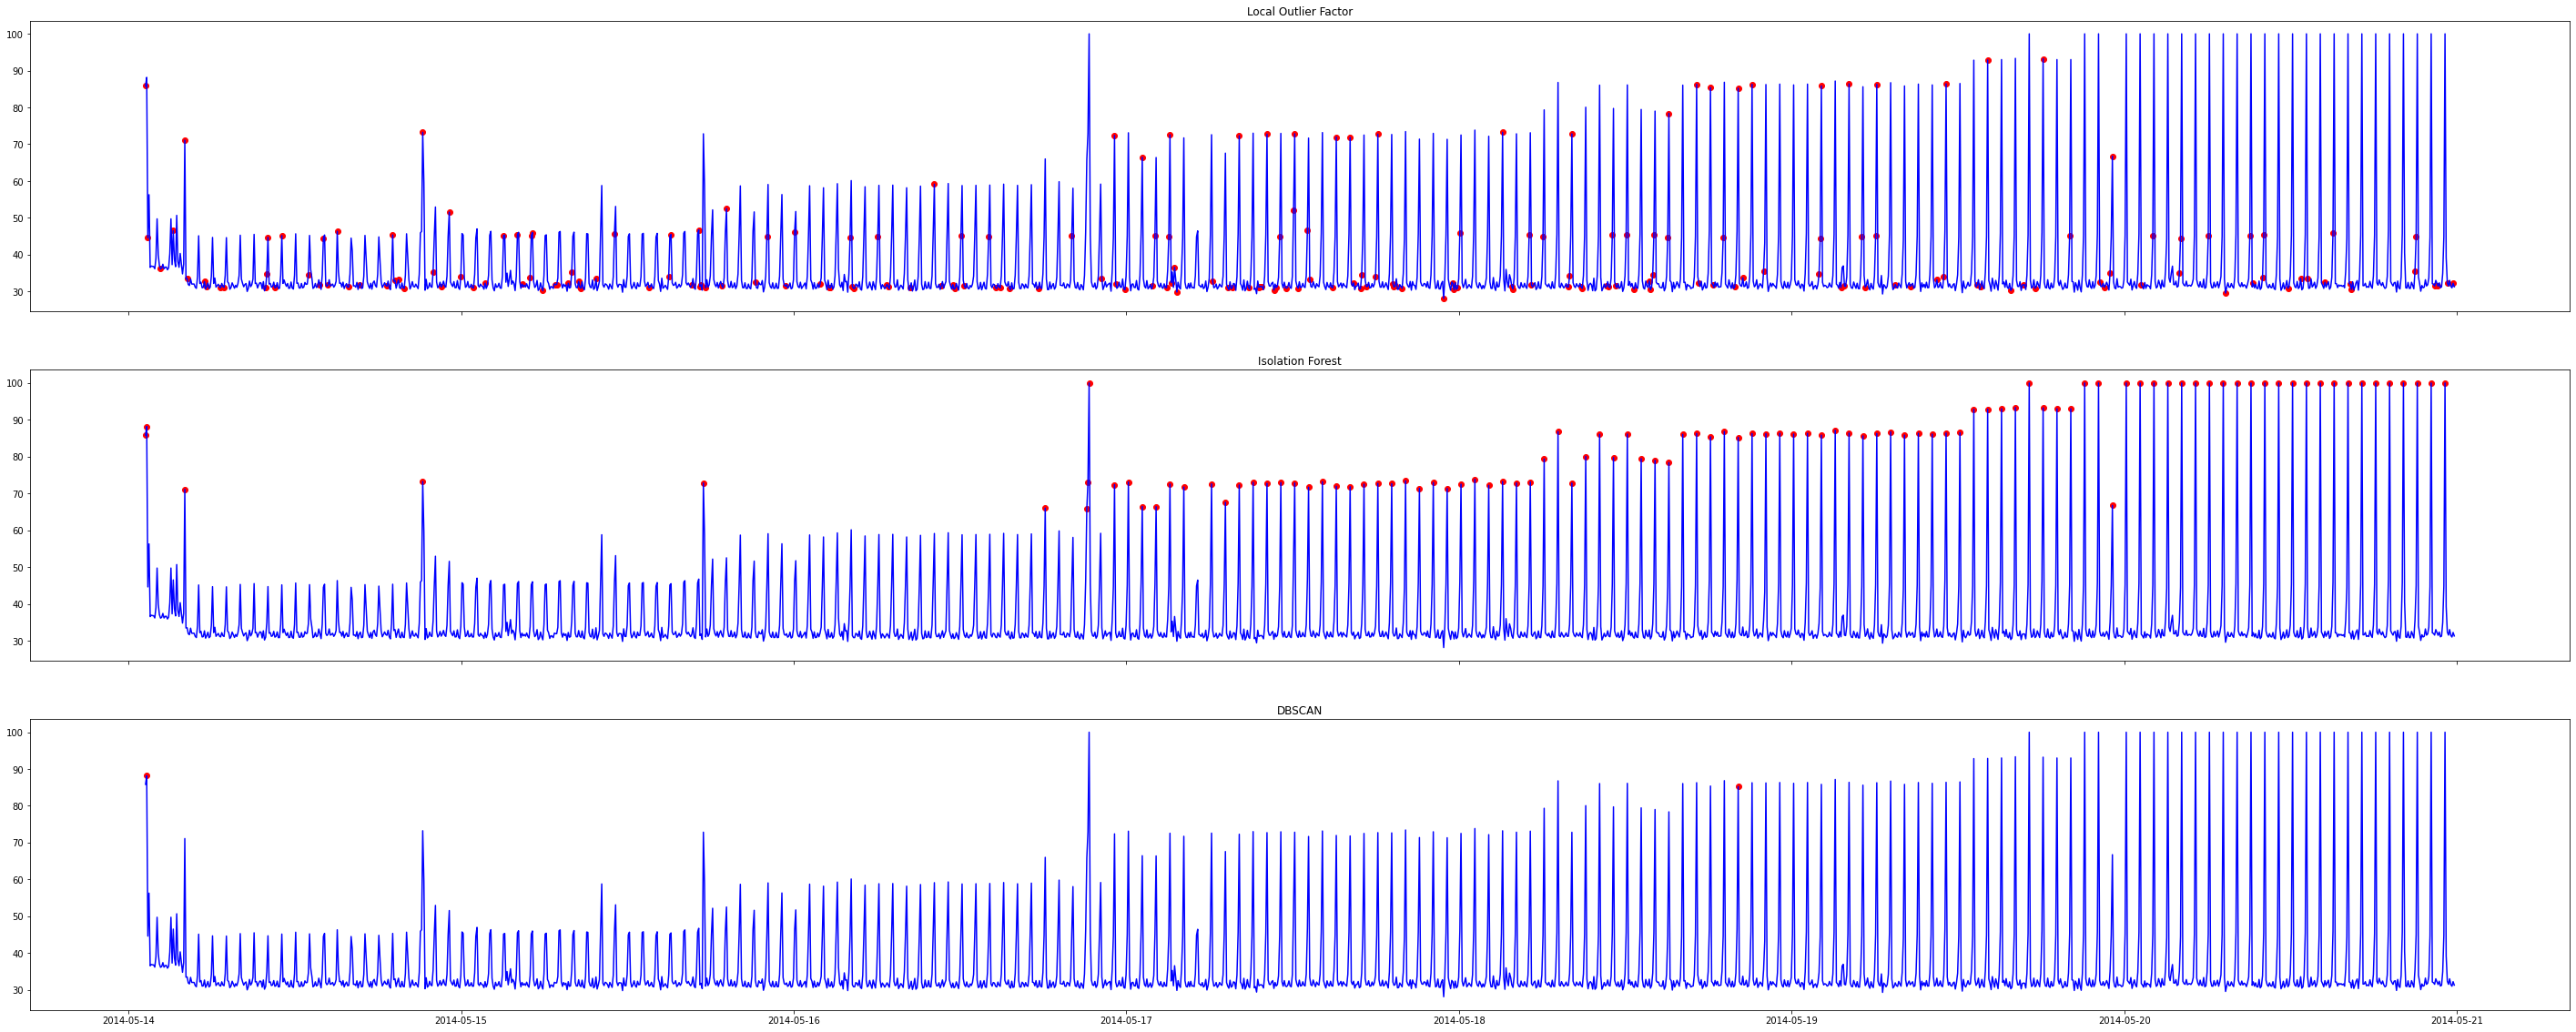

In [15]:
lof_outliers = df.loc[df['Predictions_LocalOutlierFactor'] == -1, ['value']][:218] # -1 is an anomaly
if_outliers = df.loc[df['Predictions_IsolationForest'] == -1, ['value']][:105] # -1 is an anomaly
dbscan_outliers = df.loc[df['Predictions_DBSCAN'] == -1, ['value']][:2] # -1 is an anomaly

fig, axs = plt.subplots(3, figsize=(50,20),sharex=True,sharey=True)
axs[0].plot(df.index[:2000], df['value'][:2000], color='blue', label = 'Data')
axs[0].scatter(x=lof_outliers.index,y=lof_outliers['value'], color='red', label = 'LOF Anomaly')
axs[0].set_title('Local Outlier Factor')

axs[1].plot(df.index[:2000], df['value'][:2000], color='blue', label = 'Data')
axs[1].scatter(x=if_outliers.index,y=if_outliers['value'], color='red', label = 'IF Anomaly')
axs[1].set_title('Isolation Forest')

axs[2].plot(df.index[:2000], df['value'][:2000], color='blue', label = 'Data')
axs[2].scatter(x=dbscan_outliers.index,y=dbscan_outliers['value'], color='red', label = 'DBSCAN Anomaly')
axs[2].set_title('DBSCAN')


**Conclusion:** From all the graphs plotted we can see that Isolation forest performs best for anomaly detection among the models trained in this notebook for this dataset. Isolation forest is able find the spike in the graph and does a better job than DBSCAN or Local Outlier Factor.

The averaged 10 minute usage looked better and looks like it did improve the predictions of the model as it reduced the fluctuations in the dataset by averaging the values.

**Future Work:** For future work, as we have trained mltiple models one idea that came to my mind was to ensemble the trained models and see where all three predict an anomaly that spike is definetly an anomaly with a better precision than only one model predicting it.
